In [1]:
source = 'CCDG'
do_resample = True 
operator = 'min'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

In [3]:
import pandas as pd 
pd.set_option('display.max_columns', 30)

In [4]:
from fraction_of_DELs_that_are_singletons import get_noncoding_svs_windows

get_noncoding_svs_windows(source)

,sv_id,sv_length,alt_allele_count,N_bar,negative K_bar,negative chen zscore,sv is singleton
0,119394,1394,>1,-1.869842,-0.504937,-0.413076,False
1,119444,2521,>1,5.954858,1.065578,9.097270,False
2,119450,2511,>1,2.057544,1.007262,8.443629,False
3,119450,2511,>1,4.023027,1.455451,5.706162,False
4,119450,2511,>1,1.600825,1.789779,2.620718,False
...,...,...,...,...,...,...,...
290169,309894,5144,1,-1.036694,-0.545000,1.498359,True
290170,309894,5144,1,0.012776,0.010219,1.269136,True
290171,309894,5144,1,-1.092958,0.333405,-1.242489,True
290172,309894,5144,1,0.695360,0.432403,3.189693,True


In [5]:
from fraction_of_DELs_that_are_singletons import aggregate_over_windows

aggregate_over_windows(get_noncoding_svs_windows(source))

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,mean N_bar,min negative K_bar,mean negative K_bar,min negative chen zscore,mean negative chen zscore
0,119394,1394,>1,False,-1.869842,-1.869842,-0.504937,-0.504937,-0.413076,-0.413076
1,119444,2521,>1,False,5.954858,5.954858,1.065578,1.065578,9.097270,9.097270
2,119450,2511,>1,False,1.600825,2.560465,1.007262,1.417497,2.620718,5.590170
3,119489,3049,>1,False,2.408743,2.408743,-0.264785,-0.264785,3.518609,3.518609
4,119504,8398,>1,False,-0.945519,-0.384728,-0.041867,0.284826,0.702770,1.952018
...,...,...,...,...,...,...,...,...,...,...
64384,438421,4242,1,True,-1.184616,-1.082219,-0.329059,0.179812,-3.388068,-2.339702
64385,438447,1069,1,True,-0.775127,-0.775127,0.168243,0.168243,4.280054,4.280054
64386,438448,1540,1,True,-1.616092,-1.616092,0.996819,0.996819,-0.123849,-0.123849
64387,438489,767,1,True,-1.809946,-1.809946,1.056274,1.056274,-0.093739,-0.093739


In [6]:
from fraction_of_DELs_that_are_singletons import get_svs 

svs = get_svs(source, do_resample)
svs

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,mean N_bar,min negative K_bar,mean negative K_bar,min negative chen zscore,mean negative chen zscore
20694,223081,1251,1,True,1.112611,1.522266,-0.369288,-0.308901,-3.016191,-2.006475
10851,172488,1006,>1,False,-1.759437,-1.759437,1.022679,1.022679,-1.013232,-1.013232
9711,167915,3451,1,True,-1.872174,-0.917529,-0.302379,-0.244834,-4.435655,-1.665760
43428,342220,8759,1,True,-1.738703,-0.826396,-1.283287,-0.275582,-1.139131,0.600532
26455,256713,3209,1,True,1.969538,2.543922,-1.762043,-1.161785,5.360494,5.619103
...,...,...,...,...,...,...,...,...,...,...
46597,355381,1929,>1,False,-0.086971,0.191826,-0.741601,-0.722495,-1.075777,-0.089905
63309,433093,2429,1,True,-0.806681,-0.098184,-1.083204,-0.562817,0.847252,1.115444
48421,363548,5555,1,True,-2.366580,-0.874031,-0.960053,-0.294246,-0.590089,0.586456
47433,359970,3533,1,True,-1.274751,-0.945039,-0.555895,-0.375500,-0.068223,0.293213


In [7]:
from fraction_of_DELs_that_are_singletons import (
    parameters_to_estimate_singleton_probability_under_null,
    label_svs_with_length_quantiles
)

params = parameters_to_estimate_singleton_probability_under_null[source]  

svs = label_svs_with_length_quantiles(svs, params)
svs 

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,mean N_bar,min negative K_bar,mean negative K_bar,min negative chen zscore,mean negative chen zscore,sv length quantile
20694,223081,1251,1,True,1.112611,1.522266,-0.369288,-0.308901,-3.016191,-2.006475,28
10851,172488,1006,>1,False,-1.759437,-1.759437,1.022679,1.022679,-1.013232,-1.013232,21
9711,167915,3451,1,True,-1.872174,-0.917529,-0.302379,-0.244834,-4.435655,-1.665760,59
43428,342220,8759,1,True,-1.738703,-0.826396,-1.283287,-0.275582,-1.139131,0.600532,86
26455,256713,3209,1,True,1.969538,2.543922,-1.762043,-1.161785,5.360494,5.619103,56
...,...,...,...,...,...,...,...,...,...,...,...
46597,355381,1929,>1,False,-0.086971,0.191826,-0.741601,-0.722495,-1.075777,-0.089905,41
63309,433093,2429,1,True,-0.806681,-0.098184,-1.083204,-0.562817,0.847252,1.115444,48
48421,363548,5555,1,True,-2.366580,-0.874031,-0.960053,-0.294246,-0.590089,0.586456,75
47433,359970,3533,1,True,-1.274751,-0.945039,-0.555895,-0.375500,-0.068223,0.293213,60


In [8]:
from fraction_of_DELs_that_are_singletons import aggregate_over_length_quantiles

aggregated_over_length_quantiles = aggregate_over_length_quantiles(svs, params)
aggregated_over_length_quantiles

sv length quantile      sv_length       sv is singleton        \
                                mean count            mean count   
0                   0     103.512422   644        0.645963   644   
1                   1     111.272171   654        0.617737   654   
2                   2     119.537555   679        0.628866   679   
3                   3     128.355662   627        0.655502   627   
4                   4     139.401587   630        0.661905   630   
..                ...            ...   ...             ...   ...   
95                 95   19113.698758   644        0.697205   644   
96                 96   24064.190994   644        0.687888   644   
97                 97   32419.337481   643        0.704510   643   
98                 98   48198.802795   644        0.695652   644   
99                 99  106287.259317   644        0.768634   644   

   estimated singleton probability under null  
                                               
0                                    0.650319  
1                                    0.606129  
2                                    0.630924  
3                                    0.664996  
4                                    0.672134  
..                                        ...  
95                                   0.683039  
96                                   0.687012  
97                                   0.692165  
98                                   0.710363  
99                                   0.764277  

[100 rows x 6 columns]

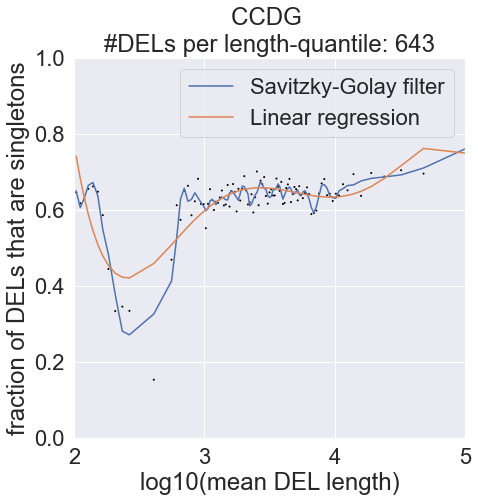

In [9]:
import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (7, 7)

import seaborn as sns 
sns.set(font_scale = 2)

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

import numpy as np 

def plot_singleton_proportion_vs_sv_length_quantile(up_weight_range=None, weight_scale=None): 
    x = np.log10(aggregated_over_length_quantiles[('sv_length', 'mean')])
    y = aggregated_over_length_quantiles[('sv is singleton', 'mean')]
    y_filtered = aggregated_over_length_quantiles['estimated singleton probability under null']
    
    sample_weight = np.ones(len(x)) 
    if up_weight_range: 
        sample_weight[
            (x > up_weight_range[0]) &
            (x < up_weight_range[1])
        ] *= weight_scale

    plt.scatter(x, y, s=sample_weight, c='grey', edgecolor='black')
    plt.plot(x, y_filtered, label='Savitzky-Golay filter')    
    plt.ylim([0, 1])
    plt.xlim([2, 5])
    plt.xticks([2, 3, 4, 5])
    plt.xlabel(f'log10(mean DEL length)')
    plt.ylabel(f'fraction of DELs that are singletons')
    mean_number_svs_per_length_quantile = int(np.mean(aggregated_over_length_quantiles[('sv_length', 'count')]))
    plt.title(f'{source} \n#DELs per length-quantile: {mean_number_svs_per_length_quantile}')
    
    model = make_pipeline(PolynomialFeatures(params['degree']), LinearRegression())
    x = np.array(x)
    X = x[:, np.newaxis]
    y = np.array(y)    
    model.fit(X, y, linearregression__sample_weight=sample_weight)
    y_hat = model.predict(X)
    plt.plot(x, y_hat, label='Linear regression')
    
    plt.legend()
    
plot_singleton_proportion_vs_sv_length_quantile()

In [10]:
from fraction_of_DELs_that_are_singletons import label_svs_with_null_statistics

svs = label_svs_with_null_statistics(svs, aggregated_over_length_quantiles)
svs

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,mean N_bar,min negative K_bar,mean negative K_bar,min negative chen zscore,mean negative chen zscore,sv length quantile,mean(isSingleton) under null,variance(isSingleton) under null
0,223081,1251,1,True,1.112611,1.522266,-0.369288,-0.308901,-3.016191,-2.006475,28,0.623883,0.234653
1,434417,1272,>1,False,1.671968,2.144537,-2.517739,-1.047229,-3.676921,-1.985756,28,0.623883,0.234653
2,300590,1268,>1,False,-0.100745,-0.100745,0.285196,0.285196,-0.693190,-0.693190,28,0.623883,0.234653
3,205874,1258,>1,False,0.448421,0.448421,0.574118,0.574118,-2.000464,-2.000464,28,0.623883,0.234653
4,145298,1263,>1,False,-2.024894,-2.024894,1.399042,1.399042,-1.228439,-1.228439,28,0.623883,0.234653
...,...,...,...,...,...,...,...,...,...,...,...,...,...
64384,128509,1132,1,True,-1.583557,0.089581,-0.874445,-0.164844,-3.191528,-0.664278,25,0.627914,0.233638
64385,223271,1160,1,True,0.632143,0.632143,0.897565,0.897565,0.713911,0.713911,25,0.627914,0.233638
64386,363622,1130,1,True,-0.429982,0.413530,-0.307451,0.012977,1.175434,1.396307,25,0.627914,0.233638
64387,175237,1155,1,True,1.698120,1.698120,-1.193980,-1.193980,3.216913,3.216913,25,0.627914,0.233638


In [11]:
from fraction_of_DELs_that_are_singletons import label_svs_with_score_quantiles

label_svs_with_score_quantiles(svs, score='negative K_bar', operator=operator, params=params)

,sv_id,sv_length,alt_allele_count,sv is singleton,min N_bar,mean N_bar,min negative K_bar,mean negative K_bar,min negative chen zscore,mean negative chen zscore,sv length quantile,mean(isSingleton) under null,variance(isSingleton) under null,(min negative K_bar) quantile
0,223081,1251,1,True,1.112611,1.522266,-0.369288,-0.308901,-3.016191,-2.006475,28,0.623883,0.234653,0.5 - 0.75
1,434417,1272,>1,False,1.671968,2.144537,-2.517739,-1.047229,-3.676921,-1.985756,28,0.623883,0.234653,0.0 - 0.02
2,300590,1268,>1,False,-0.100745,-0.100745,0.285196,0.285196,-0.693190,-0.693190,28,0.623883,0.234653,0.75 - 0.9
3,205874,1258,>1,False,0.448421,0.448421,0.574118,0.574118,-2.000464,-2.000464,28,0.623883,0.234653,0.75 - 0.9
4,145298,1263,>1,False,-2.024894,-2.024894,1.399042,1.399042,-1.228439,-1.228439,28,0.623883,0.234653,0.95 - 0.98
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64384,128509,1132,1,True,-1.583557,0.089581,-0.874445,-0.164844,-3.191528,-0.664278,25,0.627914,0.233638,0.25 - 0.5
64385,223271,1160,1,True,0.632143,0.632143,0.897565,0.897565,0.713911,0.713911,25,0.627914,0.233638,0.9 - 0.95
64386,363622,1130,1,True,-0.429982,0.413530,-0.307451,0.012977,1.175434,1.396307,25,0.627914,0.233638,0.5 - 0.75
64387,175237,1155,1,True,1.698120,1.698120,-1.193980,-1.193980,3.216913,3.216913,25,0.627914,0.233638,0.25 - 0.5


In [12]:
from fraction_of_DELs_that_are_singletons import aggregate_over_score_quantiles 

aggregate_over_score_quantiles(label_svs_with_score_quantiles(svs, score='negative K_bar', operator=operator, params=params), score='negative K_bar', operator=operator)

(min negative K_bar) quantile sv is singleton         \
                                            sum  count   
0                    0.0 - 0.02             933   1289   
1                   0.02 - 0.05            1249   1928   
2                    0.05 - 0.1            2099   3211   
3                    0.1 - 0.25            6408   9641   
4                    0.25 - 0.5           10264  16103   
5                    0.5 - 0.75            9944  16042   
6                    0.75 - 0.9            5698   9632   
7                    0.9 - 0.95            1859   3217   
8                   0.95 - 0.98            1080   1934   
9                    0.98 - 1.0             655   1277   

  mean(isSingleton) under null        variance(isSingleton) under null         \
                           sum  count                              sum  count   
0                   868.712167   1289                       277.652583   1289   
1                  1269.602589   1928                       426.629071   1928   
2                  2088.881705   3211                       719.971249   3211   
3                  6174.184877   9641                      2190.698641   9641   
4                 10128.507808  16103                      3689.991718  16103   
5                  9932.000882  16042                      3691.680009  16042   
6                  5856.668729   9632                      2221.245226   9632   
7                  1946.087602   3217                       743.690571   3217   
8                  1159.552333   1934                       447.141852   1934   
9                   751.257673   1277                       294.788875   1277   

  observed F mean(F) under null variance(F) under null  \
                                                         
0   0.723817           0.673943               0.000167   
1   0.647822           0.658508               0.000115   
2   0.653690           0.650539               0.000070   
3   0.664661           0.640409               0.000024   
4   0.637397           0.628983               0.000014   
5   0.619873           0.619125               0.000014   
6   0.591570           0.608043               0.000024   
7   0.577868           0.604939               0.000072   
8   0.558428           0.599562               0.000120   
9   0.512921           0.588299               0.000181   

  Adjusted Proportion of Singletons zscore(F)  
                                               
0                          0.049874  3.858139  
1                         -0.010686 -0.997463  
2                          0.003151  0.377094  
3                          0.024252  4.995527  
4                          0.008414  2.230497  
5                          0.000748  0.197486  
6                         -0.016473 -3.366612  
7                         -0.027071 -3.193451  
8                         -0.041134 -3.762099  
9                         -0.075378 -5.606345

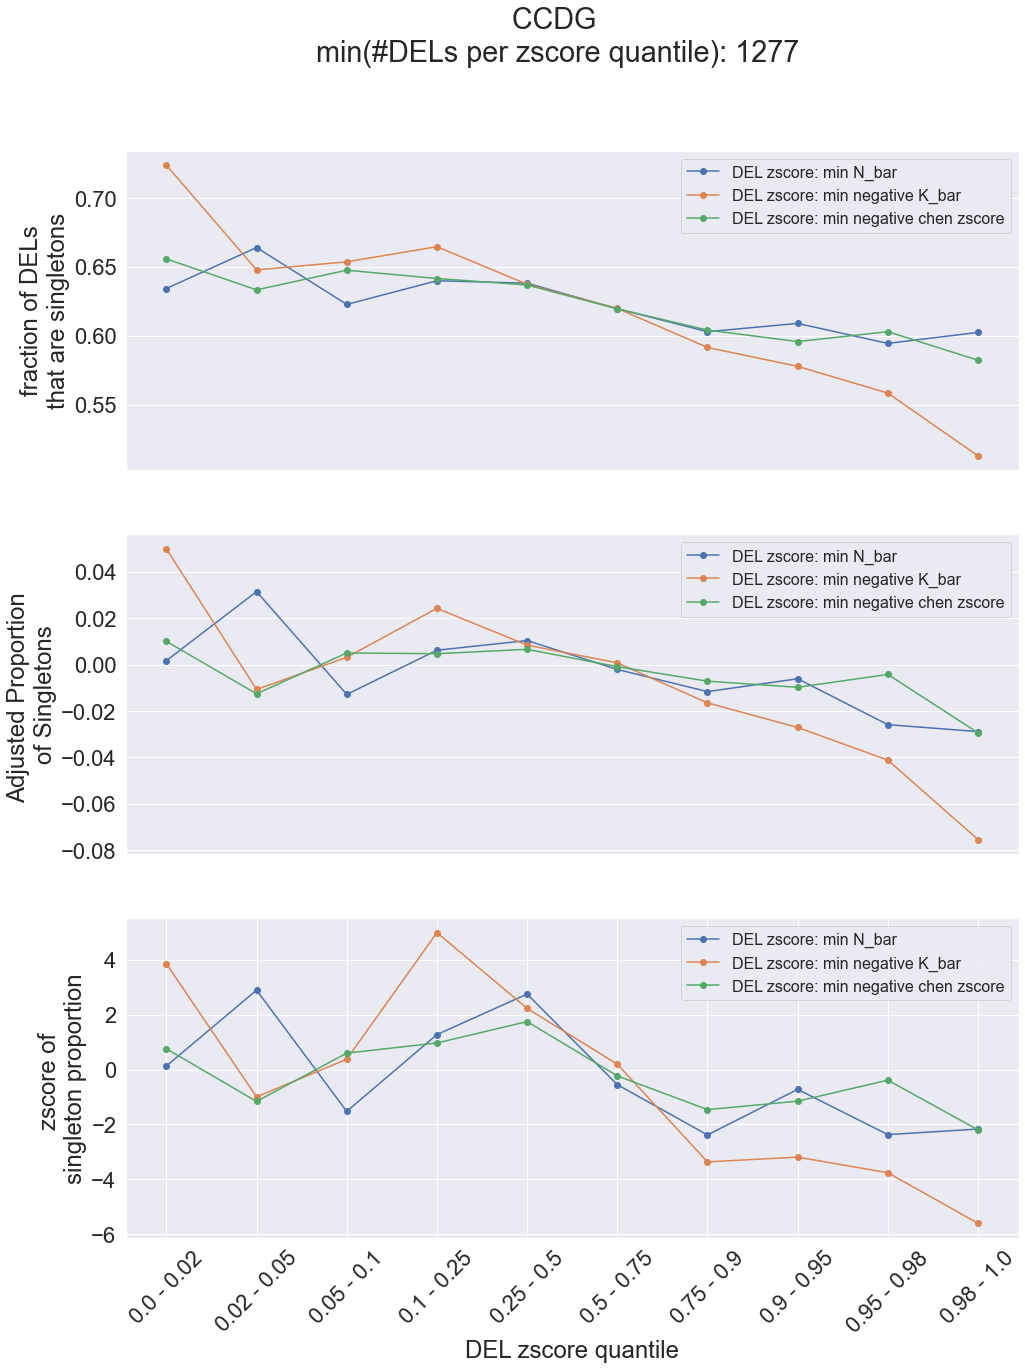

In [13]:
plt.rcParams["figure.figsize"] = (16, 20)

def plot_singleton_proportion_vs_score_quantile_core(score): 
    df = label_svs_with_score_quantiles(svs, score, operator, params)
    df = aggregate_over_score_quantiles(df, score, operator)
    min_number_svs_per_zscore_quantile = int(np.min(df[('sv is singleton', 'count')]))    

    plt.subplot(3, 1, 1)
    plt.plot(df[f'({operator} {score}) quantile'], df['observed F'], 'o-', label=f'DEL zscore: {operator} {score}')
    plt.xticks([])
    plt.ylabel('fraction of DELs\nthat are singletons')
    plt.legend(fontsize=16)
#     plt.ylim([0, 1])

    plt.subplot(3, 1, 2)
    plt.plot(df[f'({operator} {score}) quantile'], df['Adjusted Proportion of Singletons'], 'o-', label=f'DEL zscore: {operator} {score}')
    plt.ylabel('Adjusted Proportion \nof Singletons')
    plt.legend(fontsize=16)
    plt.xticks([])
#     plt.ylim([-0.15, 0.15])
    
    plt.subplot(3, 1, 3)
    plt.plot(df[f'({operator} {score}) quantile'], df['zscore(F)'], 'o-', label=f'DEL zscore: {operator} {score}')
    plt.ylabel('zscore of \nsingleton proportion')
    plt.legend(fontsize=16)
    plt.xticks(rotation = 45)
#     plt.ylim([-7, 5])

    return min_number_svs_per_zscore_quantile

def plot_singleton_proportion_vs_score_quantile(): 
    min_number_svs_per_zscore_quantile = min(
        plot_singleton_proportion_vs_score_quantile_core(score='N_bar'),
        plot_singleton_proportion_vs_score_quantile_core(score='negative K_bar'),
        plot_singleton_proportion_vs_score_quantile_core(score='negative chen zscore')
    )
    plt.suptitle(f'{source} \nmin(#DELs per zscore quantile): {min_number_svs_per_zscore_quantile}')
    plt.xlabel(f'DEL zscore quantile')
    
plot_singleton_proportion_vs_score_quantile()

In [14]:
# TODO: 
# 1. bootstrap: 
#   a. pull out code from this notebook into a function in fraction_of_DELs_that_are_singletons.py, 
#   b. call function 100 times, each time adding to a dict with zscore quantiles as keys, and APS realizations as values 
#   c. for each key, compute the 2.5 and 97.5 percentiles of the values, which yield the lower and upper bounds of the 95% confidence interval
#   d. finally, plot original APS values, together with the lower and upper interval bounds, as a function of zscore quantile
# 2. point out that we are demonstrating that there is the expected correlation between 
#   a. paucity of SNVS and paucity of SVs (other notebook)
#   b. enrichment of SNV singletons and enrichment of SV singletons (this notebook)
# 3. use K_bar in other notebook to predict regions where there are fewer DELs; expect to find that N_bar "does better" than K_bar